# Autoencoder v1.1
Enhancements made to v1

### Information
1. Eight-layer architecture (4 in encoder + 4 in decoder)
2. Dataset - 1000 STL files
3. Train - 800 models
4. Test - 200 models
5. Epochs - 50
6. Loss - 0.0216

### Changes w.r.t. v1
- Point cloud conversion now generates point clouds with 15k points instead of 10k points (change carried over from v1.1)
- ReLU replaced with ELU

### Encoder architecture
- Conv3D(32, (3, 3, 3), activation='elu', padding='same')
- MaxPooling3D((2, 2, 2), padding='same')
- Conv3D(16, (3, 3, 3), activation='elu', padding='same')
- MaxPooling3D((2, 2, 2), padding='same')

### Importing all necessary libraries

In [2]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, GlobalMaxPooling3D
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

2023-10-25 15:50:00.427880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 15:50:00.427921: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 15:50:00.427966: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 15:50:00.436387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting STL to point cloud

**Execute the following cell if you wish to delete all existing point cloud files in abc-dataset-ply/ directory**

In [3]:
folder_path = "abc-dataset-ply/"
files = os.listdir(folder_path)

for file in files:
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file}: {str(e)}")

**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [4]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl/"))
for i in files:
    path = "abc-dataset-stl/" + i
    ConversionUtils.stl_to_ply(path, 15000)

### Converting point cloud to binary voxel arrays

In [3]:
directory = "abc-dataset-ply/"
# Taking first 1000 models
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path)
    dataset.append(binvox)

In [4]:
print(len(dataset))

1000


### Splitting dataset for training and testing

In [5]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:800]  # Adjust the number as needed
test_dataset = dataset[800:]   # The remaining data for testing
print(len(train_dataset), len(test_dataset))
# Define the input shape
input_shape = (64, 64, 64, 1)

800 200


### Encoder

In [8]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='elu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='elu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

### Decoder

In [9]:
x = Conv3D(16, (3, 3, 3), activation='elu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='elu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Training autoencoder, prediction done on test dataset

In [10]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=50, batch_size=10, validation_data=(test_dataset, test_dataset))

2023-10-25 15:52:11.467794: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-25 15:52:12.824573: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-25 15:52:13.550757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-25 15:52:13.676157: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.


Epoch 1/50


2023-10-25 15:52:15.224625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-25 15:52:19.350794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58c97aaa10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 15:52:19.350829: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-25 15:52:19.354526: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 15:52:19.437300: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - ETA: 0s - loss: 0.1362

2023-10-25 15:52:42.116438: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.


80/80 [==============================] - 31s 299ms/step - loss: 0.1362 - val_loss: 0.0464
Epoch 2/50
80/80 [==============================] - 23s 289ms/step - loss: 0.0492 - val_loss: 0.0388
Epoch 3/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0442 - val_loss: 0.0344
Epoch 4/50
80/80 [==============================] - 23s 290ms/step - loss: 0.0406 - val_loss: 0.0312
Epoch 5/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0379 - val_loss: 0.0289
Epoch 6/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0349 - val_loss: 0.0264
Epoch 7/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0328 - val_loss: 0.0247
Epoch 8/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0313 - val_loss: 0.0235
Epoch 9/50
80/80 [==============================] - 23s 292ms/step - loss: 0.0300 - val_loss: 0.0225
Epoch 10/50
80/80 [==============================] - 23s 292ms/step - loss: 0.0292 - val_loss: 0.0218


In [11]:
reconstructed_data = autoencoder.predict(test_dataset, batch_size=10)

20/20 [==============================] - 2s 80ms/step


In [12]:
encoder = Model(inputs=input_data, outputs=encoded)
encoded_data = encoder.predict(test_dataset, batch_size=10)

20/20 [==============================] - 0s 23ms/step


#### Dimensions

In [10]:
print("Shape of input data: ", test_dataset[0].shape)
print("Shape of encoded data: ", encoded_data[0].shape)
print("Shape of reconstructed data: ", reconstructed_data[0].shape)

Shape of input data:  (64, 64, 64)
Shape of encoded data:  (16, 16, 16, 16)
Shape of reconstructed data:  (64, 64, 64, 1)


In [11]:
# This will convert the encoded data of each model (which is of shape 16x16x16x16) to a 1D array of 65536 elements
encoded_data_flattened = encoded_data[0].flatten()
print("Shape of encoded data after flattening: ", encoded_data_flattened.shape)
# This will convert the above array of 65536 elements back to the original encoder output of 8x8x8x8 dimensions (4D array)
encoded_regenerated = encoded_data_flattened.reshape(16, 16, 16, 16)
print("Shape of encoded data after reshaping flattened array format: ", encoded_regenerated.shape)

Shape of encoded data after flattening:  (65536,)
Shape of encoded data after reshaping flattened array format:  (16, 16, 16, 16)


### Sample reconstruction from test dataset

In [13]:
import matplotlib.pyplot as plt

index = 50

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

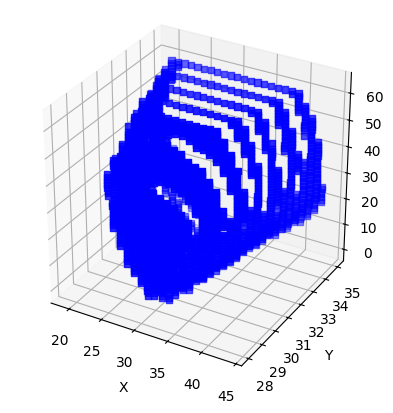

In [14]:
Visualization.matplotlib_visualize_original(original_sample)

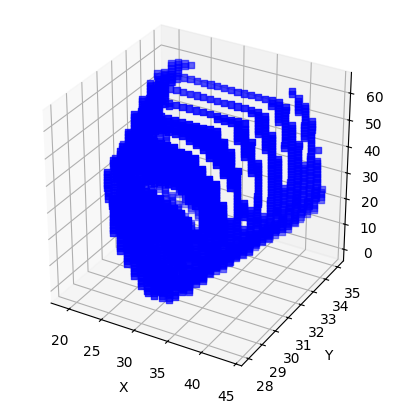

In [16]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [ ]:
Visualization.open3d_visualize_original(original_sample)

In [ ]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)